In [1]:
# One-stroke Kolam Generation 210419
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(seed=1)

In [42]:
class KolamDraw(object):
           
    def __init__(self,ND):
        # Initialization GitHub Version
        # ND - Kolam dimension odd integer > 3
        # Nx - Extended kolam dimension
        # A1 - Gate matrix
        # F1 - Occupancy companion matrix
        # Ns - Maximum number of kolam segments possible in a one-stroke kolam
 
        self.ND = ND   
        self.Nx = ND + 1
        self.A1 = np.ones((self.Nx,self.Nx))*99
        self.F1 = np.ones((self.Nx,self.Nx))
        self.Ns = 2*(self.ND**2 + 1) + 5

    def ResetGateMatrix(self):
        # Resets both gate matrix and the occupancy companion matrix
        # Establishes kolam boundaries
    
        Nx2 = int(self.Nx/2)
        Nx1 = self.Nx - 1
        A = self.A1*1
        F = self.F1*1
        
        for i in range(self.Nx):
            A[0,i] = A[i,0] = A[self.Nx-1,i] = A[i,self.Nx-1] = 0
            F[0,i] = F[i,0] = F[self.Nx-1,i] = F[i,self.Nx-1] = 0
        for i in range(1,self.Nx-1):
            A[i,i] = A[i,self.Nx-1-i] = 1
            F[i,i] = F[i,self.Nx-1-i] = 0

        return(A, F)
                        
    def toss(self,bias):
        # Returns a biased random output
        # Called out in AssignGates
        
        x = np.random.randint(0,1000)/1000
        if x > bias:
            return (1)
        else:
            return (0)
                         
    def AssignGates(self,krRef,Kp,Ki):
        # Assigns random gate distribution
        # Called out in Dice
        
        A, F = self.ResetGateMatrix()
        Asum = A.sum()
        Fsum = F.sum()

        errAckr = 0.0
        count1 = 0
        count01 = 1
        Nx1 = self.Nx-1
        Nx2 = int(self.Nx/2)

        for i in range (1,Nx2):
            for j in range (i,self.Nx-i):
                errkr = krRef - (count1/count01)
                errAckr = errAckr + errkr
                kr = krRef + Kp*errkr + Ki*errAckr
                
                if F[i,j] == 1:
                    if F[i,j+1] == 1:
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-i] = self.toss(kr)
                        F[i,j] = F[j,i] = F[Nx1-i,Nx1-j] = F[Nx1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j] > 0.9:
                            count1 = count1 + 4
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j]) < 0.1:
                            x = 1
                        else:
                            # x = self.flip.toss(kr)
                            x = self.toss(kr)
                        A[i,j+1] = A[j+1,i] = A[Nx1-i,Nx1-1-j] = A[Nx1-1-j,Nx1-i] = x
                        F[i,j+1] = F[j+1,i] = F[Nx1-i,Nx1-1-j] = F[Nx1-1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j+1] > 0.9:
                            count1 = count1 + 4
                    if F[i,j+1] <= 0:
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j+1]) < 0.1:
                            x = 1
                        else:
                            x = self.toss(kr)
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-i] = x
                        F[i,j] = F[j,i] = F[Nx1-i,Nx1-j] = F[Nx1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j] > 0.9:
                            count1 = count1 + 4
                
                if F[i,j] <= 0:
                    if F[i,j+1] == 1:
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j]) < 0.1:
                            x = 1
                        else:
                            x = self.toss(kr)
                        A[i,j+1] = A[j+1,i] = A[Nx1-i,Nx1-1-j] = A[Nx1-1-j,Nx1-i] = x
                        F[i,j+1] = F[j+1,i] = F[Nx1-i,Nx1-1-j] = F[Nx1-1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j+1] > 0.9:
                            count1 = count1 + 4
        
        return(A, F, kr)
    
    def ReadGates (self, ARead, BRead):
        
        self.A = ARead
        self.F = BRead
        
        return(self.A, self.F)
    
    def NextStep(self,icg,jcg,ce):
        # Generates the next kolam evolution path given a current coordinate and a entry direction, given a gate dist.
        # Called out in XNextSteps, FlipTestSwitch, FlipTestSwitchRandom, PathCount
        
        icgx = icg + self.ND
        jcx = jcg + self.ND
        icgx2 = int(np.floor(icgx/2))
        jcx2 = int(np.floor(jcx/2))

        calpha = np.mod(ce,2)
        if ce>1:
            cbeta = -1
        else:
            cbeta = 1
        if np.mod(int(icgx + jcx),4) == 0:
            cgamma = -1
        else:
            cgamma = 1
        
        if self.A[icgx2,jcx2]>0.5:
            cg = 1
        else:
            cg = 0
            
        cgd = 1-cg
        calphad = 1-calpha
        nalpha = cg*calpha + cgd*calphad
        nbeta = (cg + cgd*cgamma)*cbeta
        nh = (calphad*cgamma*cgd + calpha*cg)*cbeta
        nv = (calpha*cgamma*cgd + calphad*cg)*cbeta
        ing = int(icg + nh*2)
        jng = int(jcg + nv*2)
        ingp = icg + cgd*(calphad*cgamma - calpha)*cbeta*0.5
        jngp = jcg + cgd*(calpha*cgamma - calphad)*cbeta*0.5
        
        if nalpha == 0:
            if nbeta == 1:
                ne = 0
            else:
                ne = 2
        if nalpha == 1:
            if nbeta == 1:
                ne = 1
            else:
                ne = 3
                
        return(ing,jng,ne,ingp,jngp)
    
    def XNextSteps(self,icgo,jcgo,ceo,Ns):
        # Generates the next Ns steps of the kolam evolution path
        # Called out in GenerateKolam
        
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        ijcx[0,:] = [icgo,jcgo]
        cex[0] = ceo
        
        for i in range(Ns-1):
            ijcx[i+1,0], ijcx[i+1,1], cex[i+1], ijcp[i,0], ijcp[i,1] = self.NextStep(
                ijcx[i,0], ijcx[i,1], cex[i])
        return (ijcx, cex, ijcp)

    def PathCount(self):
        # Counts the number of evolving kolam segments from a fixed starting coordinate for a given gate dist. 
        # Called out in FlipTestSwitch, GenerateKolam
        
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        Flag1 = Flag2 = 0
        isx = 0
        isa = 0
         
        ijcx[0,0] = 2*np.random.randint(0,2) - 1
        ijcx[0,1] = 2*np.random.randint(0,2) - 1

        cex[0] = 0
            
        while isa < Ns-2:
                
            isa = isa + 1
                              
            ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
            if int(ijcx[isa,0]) == int(ijcx[0,0]):
                if int(ijcx[isa,1]) == int(ijcx[0,1]):
                    if int(cex[isa]) == int(cex[0]):
                        Flag1 = 1
                        isx = isa
                        isa = Ns - 1
 
                # print(ith,isa,ijcx[isa,:])
        #print ('PathCount', ijcx[0,:], isx)
        return(isx)
    
    
    def Dice(self,krRef,Kp,Ki,Nthr):
        # Performs several random gate distributions and selects the one with the longest kolam path evolution
        # Called out in GenerateKolam
        
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        krx = np.zeros((Nthr))
        ith = int(0)
        ithx = int(0)
        ismax = int(0)
        
        while ith < Nthr:
            
            self.A, self.F, krx[ith] = self.AssignGates(krRef,Kp,Ki)
            Asum = self.A.sum()
            Fsum = self.F.sum()

            Flag1 = Flag2 = 0
            isx = 0
            isa = 0
            ijcx[0,0] = ijcx[0,1] = 1
            cex[0] = 0
            
            while isa < Ns-2:
                
                isa = isa + 1
                              
                ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
                if int(ijcx[isa,0]) == int(ijcx[0,0]):
                    if int(ijcx[isa,1]) == int(ijcx[0,1]):
                        if int(cex[isa]) == int(cex[0]):
                            Flag1 = 1
                            isx = isa
                            isa = Ns - 1
                        
            if Flag1 == 1:
                if isx < Ns + 2:
                    Flag2 = 1
                    if isx > ismax:
                        ismax = isx
                        Amax = self.A
                if isx > (Ns/2) - 2:
                    Flag2 = 2
                    ithx = ith
                    ith = int(Nthr + 1)
            
                #print("Dice Ns Flag1 Flag2 isx ismax", Ns, Flag1, Flag2, isx, ismax)
                
            ith = ith + 1

        return (self.A, self.F, Amax, isx, ithx, ismax, Flag1, Flag2, krx)
    
    def SwitchGate(self, ig, jg):
        # Performs a single gate switching 
        # Called out in FlipTestSwitch, FlipTestSwitchRandom
        
        Flag = 0
        Ax = self.A*1
        Fx = self.F*1
        Nx = self.Nx
        if Ax[ig,jg] < 0.1:
            Ax[ig,jg] = Ax[jg,ig] = Ax[Nx-ig-1,Nx-jg-1] = Ax[Nx-jg-1,Nx-ig-1] = 1
            Fx[ig,jg] = Fx[jg,ig] = Fx[Nx-ig-1,Nx-jg-1] = Fx[Nx-jg-1,Nx-ig-1] = 0
            Flag = 1
        if Flag == 0:
            if Ax[ig,jg] > 0.9:
                Ax[ig,jg] = Ax[jg,ig] = Ax[Nx-ig-1,Nx-jg-1] = Ax[Nx-jg-1,Nx-ig-1] = 0
                Fx[ig,jg] = Fx[jg,ig] = Fx[Nx-ig-1,Nx-jg-1] = Fx[Nx-jg-1,Nx-ig-1] = 0
                Flag = -1
                
        return(Ax, Fx, Flag)
        
    def FlipTestSwitch(self, ksh, iL, iH):
        # Performs multiple flip test and switch action in specified range of anchor points, and retains the ones that return 
        # --the longest kolam path evolution
        # Called out in IterFlipTestSwitch
            
        Ncx = self.PathCount()
        Ns = self.Ns
        Nx2 = int(self.Nx/2)

        iLx = np.maximum(np.minimum(iL,Nx2),1)
        iHx = np.maximum(np.minimum(iH,Nx2),iLx)
        for ig in range (iLx,iHx):
            for jg in range (ig,self.Nx-1-ig):

                Ax = self.A
                Fx = self.F
              
                if self.F[ig,jg] >= 0:
                    if self.toss(ksh) == 1:
                        self.A, self.F, Flag = self.SwitchGate(ig,jg)
                        Nc = self.PathCount()

                        if Nc < Ncx:
                            self.A = Ax
                            self.F = Fx
                        if Nc > Ncx:
                            Ncx = Nc
                        if Ncx >= Ns-5:
                            break
                            
        return(Ncx)
           
    def IterFlipTestSwitch(self, ksh, Niter, iL, iH):
        # Iterate flip test and switch actions   
        Ns = self.Ns
        Ncx = self.PathCount()
        if Ncx < Ns:
            for iter in range (Niter):
                Ncx = self.FlipTestSwitch(ksh, iL, iH)
                print ("IterFlipTestSwitch:",'  iteration = ',iter, '  KoLam Length = ',Ncx)
                if Ncx >= Ns-5:
                    break
        return (Ncx, self.A, self.F)
    
    def PrimitiveCount(self):
        # Counts the primitives in a kolam for a given gate matrix
        # Called out in GenerateKolam
        
        Ax = self.A*1
        Nx = self.Nx
        xcacc = np.zeros((4))
        x2acc = np.zeros((2))
        xtot = int((self.ND**2 + 1)/2)
                
        for ig in range (self.Nx-1):
            for jg in range (self.Nx-1):
                
                xc = 0
                if np.mod(ig,2) == 0:
                    if np.mod(jg,2) == 0:
                        xc = Ax[ig,jg] + Ax[ig+1,jg] + Ax[ig+1,jg+1] + Ax[ig,jg+1]
                            
                if np.mod(ig,2) == 1:
                    if np.mod(jg,2) == 1:
                        xc = Ax[ig,jg] + Ax[ig+1,jg] + Ax[ig+1,jg+1] + Ax[ig,jg+1]
              
                xc2 = 0
                if xc == 2:
                    xc2 = 2
                    if Ax[ig,jg] + Ax[ig+1,jg+1] == 2:
                        xc2 = 1
                    if Ax[ig+1,jg] + Ax[ig,jg+1] == 2:
                        xc2 = 1 

                if xc > 0:
                    xcacc[int(xc)-1] = xcacc[int(xc)-1] + 1
                if xc2 > 0:
                    x2acc[int(xc2)-1] = x2acc[int(xc2)-1] + 1
                    
        return (xtot, np.int16([xcacc[0], x2acc[0], x2acc[1], xcacc[2], xcacc[3]]))   
    
    def MapDotMatrix (self, Ncx, ijng, ijngp):
        # This is a matrix which puts a count of the gate elements effectively traversed by the kolam path around each anchor dot
        # Ncx is the total number points traversed; ijng/ijngp is the matrix of raw/actual points traversed
        # Note this count is dependent on the origins of the column path, hence subjective
        # A count of 4 indicates that all four surrounding gate elements have been traversed
        # A count of 0 indicates that none of the four gate elements have been traversed indicating a full island
        # A count of 1, 2 or 3 indicates that only a partial number of the four gates have been traversed 
        # A count of 4 (typ. 50) indicates that the count is not relevant as it pertains to a non anchor-dot coordinate
        # Called out in GenerateKolam
        
        ND = self.ND
        
        D = np.zeros((ND,ND))
        
        # Intial count for non anchor-dot coordinates are set to 100 to discard them from relevance
        for i in range (ND):
            for j in range (ND):
                if np.mod(i+j,2) != 0:
                    D[i,j] = 100 
        
        # 
        for i in range (Ncx):

            if ijngp[i,0] != ijng[i,0]:
                D[int(ijngp[i,0]-0.5*(ijng[i,0]-ND+1)),int(ijngp[i,1]-0.5*(ijng[i,1]-ND+1))] += 2
                                              
            if ijngp[i,0] == ijng[i,0]:
                if np.mod(ijng[i,0] + ijng[i,1],4) == 0:
                    D[int(0.5*(ijng[i,0]+1+ND-1)),int(0.5*(ijng[i,1]-1+ND-1))] += 1
                    D[int(0.5*(ijng[i,0]-1+ND-1)),int(0.5*(ijng[i,1]+1+ND-1))] += 1

                if np.mod(ijng[i,0] + ijng[i,1],4) != 0:                                        
                    D[int(0.5*(ijng[i,0]+1+ND-1)),int(0.5*(ijng[i,1]+1+ND-1))] += 1
                    D[int(0.5*(ijng[i,0]-1+ND-1)),int(0.5*(ijng[i,1]-1+ND-1))] += 1
            
        D = D/2
        
        return (D)
    
    def FindBlank (self, D):
        # Computes the number of anchor-dots with incomplete kolam paths surrounding each anchor-dot.
        # Called out in GenerateKolam
        
        ND = self.ND
        
        ijb = np.zeros((1,2))
        ijbd = np.zeros((1,2))
        Flag = 0
        NBlnk = 0
        
        i = j = 0
        while i < ND:
            j = 0
            while j < ND:
                if D[i,j] < 4:
                    ijb = [(2*i)-ND+1,(2*j)-ND+1]
                    ijbd = [i,j]
                    Flag = 1
                    NBlnk = NBlnk + 1
                    # i = j = ND+1
                j = j+1
            i = i+1

        return (ijb, ijbd, Flag, NBlnk)
       
    def loadfile (self, Afile, Ffile):
        
        self.A = Afile
        self.F = Ffile
        
        return 
                

In [51]:
#Let us now write the routines required for generating multiple kolams and saving
def plotkolam (ijngp):
    Ncx = np.shape(ijngp)[0]
    fig, ax = plt.subplots(figsize = (5,5))

    ijngpx = (ijngp[:,0] + ijngp[:,1])/2
    ijngpy = (ijngp[:,0] - ijngp[:,1])/2
    ax.plot(ijngpx[0:Ncx-1], ijngpy[0:Ncx-1] , '0.5')

    Mn = -(ND+1)
    Mx = ND+1
    plt.axis('off')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.xlim(Mn,Mx)
    plt.ylim(Mn,Mx)
    plt.show()
    return

def GenerateKolam (ND, sigma_ref):

    Kp = 0.01              # Proportional gain for aesthetic control
    Ki = 0.0001            # Integral gain for aesthetic control
    ksh = 0.5              # Parameter for fts switching 
    Niter = 50             # Number of iterations for flip-test-switch runs
    Nthr = 10  
    # ND: Kolam dimension (odd integer >= 5)
    # krRef: Initial ratio of 1 in gate elements (set 0.75 for now), 
    # Kp, Ki: prop & integral gains for krRef tracking (0.01, 0.0001 for now)
    # Nthr: Number of random throws for picking the best initial selection in terms of the kolam paths
    
    krRef = 1 - sigma_ref
    KD = KolamDraw(ND)
    A2, F2, A2max, isx, ithx, ismax, Flag1, Flag2, krx2 = KD.Dice(krRef, Kp, Ki, Nthr)
    Ncx = KD.PathCount()
    
    Nx2x = int((ND+1)/2)

    Ncx, GM, GF = KD.IterFlipTestSwitch (ksh, Niter, 1, Nx2x)
    Ns = 2*(ND**2 + 1) + 5
    icgo = 1
    jcgo = 1
    ceo = 1
    ijng,ne,ijngp = KD.XNextSteps(icgo,jcgo,ceo,Ns)
    DM = KD.MapDotMatrix(Ncx, ijng, ijngp)
    ijbx, ijbdx, Flagx, NBlnk = KD.FindBlank (DM)
    print ('GenerateKolam: Kolam Length = ', Ncx, '  Possible Max Length = ', Ns-5, '  No. of Blanks = ', NBlnk)
    
    if Ncx == Ns-5:
        xtot, xacc = KD.PrimitiveCount() 
        print ('Total primitives = ', xtot, 'Primitives [drop, door, eye, fan, diamond] = ', xacc)
        plotkolam (ijngp)
        return GM, xtot, xacc
    
    else:
        print ("Not converging")
        return 0, 0, 0


IterFlipTestSwitch: iteration =  0 KoLam Length =  884
GenerateKolam: Kolam Length =  884   Possible Max Length =  884   No. of Blanks =  0
Total primitives =  221 Primitives [drop, door, eye, fan, diamond] =  [48 32 44 60 37]


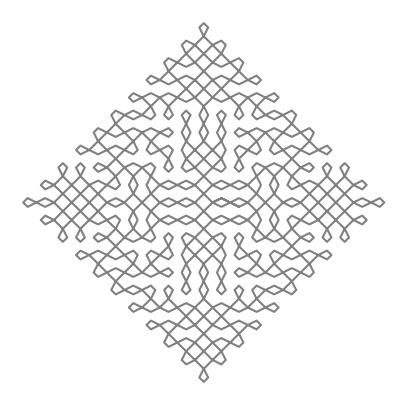

IterFlipTestSwitch: iteration =  0 KoLam Length =  884
GenerateKolam: Kolam Length =  884   Possible Max Length =  884   No. of Blanks =  0
Total primitives =  221 Primitives [drop, door, eye, fan, diamond] =  [72 42 44 40 23]


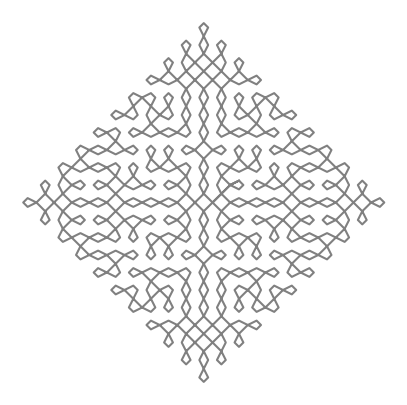

In [52]:
ND = 21
sigma_ref = 0.5

for i in range (2):
    GMa, xtot, xacc = GenerateKolam (ND, sigma_ref)